In [1]:
import sys
sys.path.insert(0, '../utils')
from helper import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='../Evaluation Sets/Raptor Contract.docx', collection_name='contract', embedding_function=embedding_function)
chroma_collection.count()

/home/mahbubah/Desktop/week-11/.venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


650

In [3]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [4]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/mahbubah/Desktop/week-11/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 650/650 [10:49<00:00,  1.00it/s]


In [5]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert contract advisor assistant. Provide an example answer to the given question, that might be found in a document like the contract."
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [6]:
original_query = "What is the purpose of the escrow?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

What is the purpose of the escrow? The purpose of the escrow is to hold
funds or assets on behalf of the parties involved in the agreement
until specified conditions are met. This helps ensure that both parties
fulfill their obligations and mitigates the risk of non-payment or
non-delivery.


In [7]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

this agreement, the escrow agreement or the contemplated transactions ;

at the closing, buyer shall deposit the escrow amount with the escrow
agent to be held in a separate account ( the “ escrow account ” ). the
escrow account shall be governed by the terms of the escrow agreement.
all funds contained in the escrow account shall be held in escrow and
shall be available solely for the purpose of satisfying obligations of
the company securityholders, if any, as provided in section 2. 07 ( f
). closing deliveries.

escrow.

to the sellers ’ representative, the employment agreements and any
other ancillary agreements to be entered into by buyer or parent at
closing, executed by buyer or parent ( as applicable ) ; to the escrow
agent, by wire transfer of immediately available funds, the escrow
amount ;

at closing, buyer will deposit the escrow amount in escrow on behalf of
the sellers in accordance with the escrow agreement. the escrow amount
shall be held and, subject to section 2. 07, 

In [8]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


(3.6664303064346315, 11.382964777946473, 4.034906935691834, 11.528777050971986)

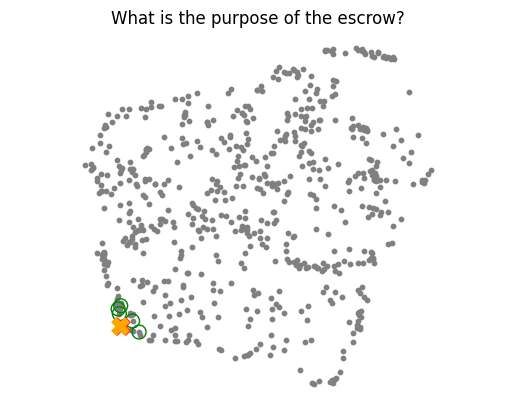

In [9]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Expansion with multiple queries

In [10]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert contract advisor assistant. Your users are asking questions about information contained in the contract."
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [11]:
original_query = "What is the purpose of the escrow?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- Who is responsible for managing the escrow?
- How is the escrow amount determined?
- What conditions need to be met before the escrow is released?
- Can the escrow amount be adjusted during the contract term?
- What happens if there is a dispute regarding the escrow funds?


In [12]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What is the purpose of the escrow?

Results:
escrow.

this agreement, the escrow agreement or the contemplated transactions ;

“ escrow amount ” means, $ 1, 000, 000 “ facilities ” means any
buildings, plants, improvements or structures located on the real
property.

at the closing, buyer shall deposit the escrow amount with the escrow
agent to be held in a separate account ( the “ escrow account ” ). the
escrow account shall be governed by the terms of the escrow agreement.
all funds contained in the escrow account shall be held in escrow and
shall be available solely for the purpose of satisfying obligations of
the company securityholders, if any, as provided in section 2. 07 ( f
). closing deliveries.

to the sellers ’ representative, the employment agreements and any
other ancillary agreements to be entered into by buyer or parent at
closing, executed by buyer or parent ( as applicable ) ; to the escrow
agent, by wire transfer of immediately available funds, the escrow
amoun

In [13]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


In [14]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


(3.6664303064346315, 11.382964777946473, 4.034906935691834, 11.528777050971986)

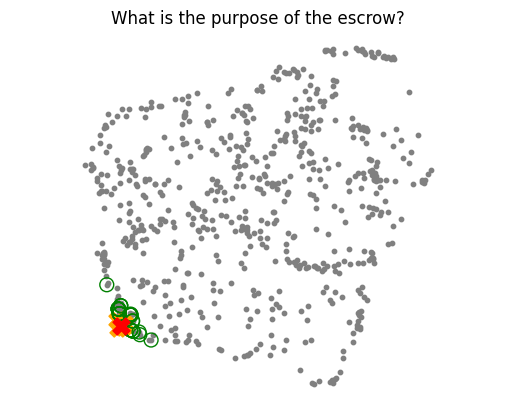

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')